In this notebook I look at the most popular categories of Google Play apps in Spain vs US.

I use the [Google Play Top Charts API](https://42matters.com/api/top-google-charts) to retrieve some data from Play.

In [225]:
from collections import Counter
from configparser import ConfigParser
import csv
import pandas as pd
from pprint import pprint as pp
import requests
%matplotlib inline

If you want to run this analysis yourself (maybe you want to check other countries), get a 42 matters API key and define a config file called notebook.conf in the same directory as this notebook, with the following values

    [vars]
    apikey = <your_api_key>
    country = <your_primary_country> -> I use ES (Spain)
    compare_country = <your_compareTo_country> -> I use US (United States)
    limit = <how_many_top_results> -> I use 20

In [226]:
list_names = ( "topselling_free", "topselling_paid", "movers_shakers", "topgrossing", "topselling_new_free", "topselling_new_paid" )

In [227]:
config = ConfigParser()
config.read("notebook.conf")

['notebook.conf']

In [223]:
access_token = config["vars"]["apikey"]
country = config["vars"]["country"]
compare_country = config["vars"]["compare_country"]
limit = config["vars"]["limit"]

In [224]:
def get_request_url(*args):
    return "https://data.42matters.com/api/v2.0/android/apps/top_google_charts.json?" +\
        "list_name={}&cat_key=OVERALL&country={}&limit={}&access_token={}".format(*args)

In [183]:
def get_top_categories_from_response(resp):
    cats = [app["category"] for app in resp["app_list"]]
    cats_count = Counter(cats)
    return dict(cats_count.most_common(5))

In [184]:
trends = {
    country: {},
    compare_country: {},
}

In [185]:
def get_stats(country):
    for lname in list_names:
        url = get_request_url(lname, country, limit, access_token)
        resp = requests.get(url).json()
        trends[country][lname] = get_top_categories_from_response(resp)

In [186]:
for co in (country, compare_country):
    get_stats(co)

In [187]:
pp(trends)

{'ES': {'topselling_free': {'Action': 2,
                            'Communication': 2,
                            'Social': 3,
                            'Sports': 2,
                            'Tools': 5},
        'topselling_paid': {'Arcade': 2,
                            'Entertainment': 2,
                            'Health & Fitness': 4,
                            'Photography': 3,
                            'Puzzle': 2}},
 'US': {'topselling_free': {'Entertainment': 2,
                            'Music & Audio': 3,
                            'Photography': 2,
                            'Social': 4,
                            'Tools': 3},
        'topselling_paid': {'Adventure': 2,
                            'Music & Audio': 2,
                            'Puzzle': 3,
                            'Role Playing': 2,
                            'Strategy': 2}}}


In [210]:
df1 = pd.DataFrame(trends[country]); df1

,topselling_free,topselling_paid
Action,2.0,NaN
Arcade,NaN,2.0
Communication,2.0,NaN
Entertainment,NaN,2.0
Health & Fitness,NaN,4.0
Photography,NaN,3.0
Puzzle,NaN,2.0
Social,3.0,NaN
Sports,2.0,NaN
Tools,5.0,NaN


In [207]:
df2 = pd.DataFrame(trends[compare_country]); df2

,topselling_free,topselling_paid
Adventure,NaN,2.0
Entertainment,2.0,NaN
Music & Audio,3.0,2.0
Photography,2.0,NaN
Puzzle,NaN,3.0
Role Playing,NaN,2.0
Social,4.0,NaN
Strategy,NaN,2.0
Tools,3.0,NaN


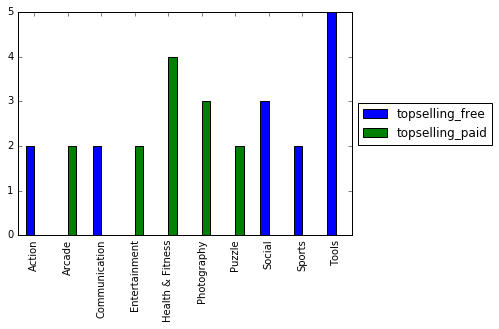

In [218]:
plt1 = df1.plot(kind="bar")
plt1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

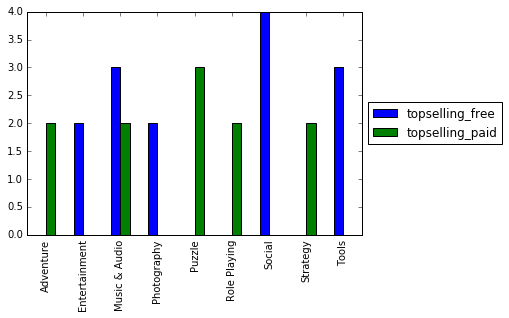

In [219]:
plt2 = df2.plot(kind="bar")
plt2.legend(loc='center left', bbox_to_anchor=(1, 0.5))